<a href="https://colab.research.google.com/github/i-saw/Downloading-the-pictures-to-the-text-query/blob/main/%D0%A1%D0%BA%D0%B0%D1%87%D0%B8%D0%B2%D0%B0%D0%B5%D0%BC_%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BA%D0%B8_%D0%BF%D0%BE_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%BC%D1%83_%D0%B7%D0%B0%D0%BF%D1%80%D0%BE%D1%81%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Установка и импорт необходимых библиотек
from IPython.display import clear_output

!pip install fake_headers
!pip install requests beautifulsoup4

import os
import re
import requests
import shutil
import time
import random
from bs4 import BeautifulSoup as bs4

clear_output()

***Главные настройки:***

In [2]:
need_object = "Пельмени"    # Что будем искать? (На разных языках можно запрашивать, это увеличит охват)
num_pages = 10             # Сколько страниц просмотрим? (чем больше число тем больше изображений, на одной в среднем 20 изображений)

In [3]:
download_folder = f'downloaded_images_{need_object}'  # Название папки для загрузки изображений
os.makedirs(download_folder, exist_ok=True)

In [4]:
#@title Парсим c Yandex картинок. Если запрос не маленький , то парсится до CAPCHA

import json
from fake_headers import Headers

class Size:
    def __init__(self):
        self.large = 'large'
        self.medium = 'medium'
        self.small = 'small'

class Preview:
    def __init__(self, url: str, width: int, height: int):
        self.url = url
        self.width = width
        self.height = height
        self.size = str(width) + '*' + str(height)

class Result:
    def __init__(self, title: (str, None), description: (str, None), domain: str, url: str, width: int, height: int, preview: Preview):
        self.title = title
        self.description = description
        self.domain = domain
        self.url = url
        self.width = width
        self.height = height
        self.size = str(width) + '*' + str(height)
        self.preview = preview

class YandexImage:
    def __init__(self, download_folder: str, temp_folder: str):
        self.download_folder = download_folder
        self.temp_folder = temp_folder

        # Создаем целевые и временные папки, если их нет
        os.makedirs(self.download_folder, exist_ok=True)
        os.makedirs(self.temp_folder, exist_ok=True)

        self.headers = Headers(headers=True).generate()

    def search(self, query: str, sizes: str = 'large', max_length: int = 150, num_pages: int = 5) -> list:
        output = []
        for page in range(num_pages):
            request = requests.get('https://yandex.ru/images/search',
                                   params={"text": query,
                                           "nomisspell": 1,
                                           "noreask": 1,
                                           "isize": sizes,
                                           "p": page
                                           },
                                   headers=self.headers)

            # Проверка на наличие CAPTCHA
            if "captcha" in request.text.lower():
                print("Обнаружена CAPTCHA! Останавливаем дальнейшие запросы.")
                break

            # Проверяем статус ответа
            if request.status_code != 200:
                print(f"Не удалось получить изображение: {request.status_code}")
                return output

            # Находим все URL-адреса, которые являются прямыми ссылками на изображения .jpg или .jpeg
            image_pattern = r'(https://[^\s"]+\.(jpg|jpeg))'
            image_urls = re.findall(image_pattern, request.text)

            # Извлекаем первый элемент (полный URL)
            image_urls = [match[0] for match in image_urls]

            # Фильтруем URL по длине и добавляем в вывод
            filtered_urls = [url for url in image_urls if len(url) <= max_length]
            output.extend(filtered_urls)

            # Скачиваем каждое изображение во временную папку
            for url in filtered_urls:
                self.download_image(url)

            # Вводим случайную задержку между запросами
            delay = random.uniform(35, 55)  # Случайная задержка между 35 и 55 секундами
            print(f"Ожидание {delay:.2f} секунд перед следующим запросом...")
            time.sleep(delay)

        return output

    def download_image(self, url: str):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Проверка на HTTP ошибки

            # Извлекаем имя файла изображения из URL
            original_filename = url.split("/")[-1]
            temp_filename = os.path.join(self.temp_folder, original_filename)

            # Записываем изображение во временную папку
            with open(temp_filename, 'wb') as f:
                f.write(response.content)


            # Проверка на дубликаты
            if not self.is_duplicate(temp_filename):
                final_filename = self.get_unique_filename(original_filename)
                shutil.move(temp_filename, final_filename)
                print(f"Файл загружен в целевую папку: {final_filename}")
            else:
                os.remove(temp_filename)
                print(f"Файл {temp_filename} является дубликатом , удаляем его.")
        except requests.exceptions.RequestException as e:
            print(f"Не удалось скачать {url}: {e}")

    def is_duplicate(self, temp_filename: str) -> bool:
        """
        Проверяет, является ли файл дубликатом, сравнивая его размер с файлами в целевой папке.
        """
        temp_file_size = os.path.getsize(temp_filename)

        # Проверяем все файлы в целевой папке
        for filename in os.listdir(self.download_folder):
            existing_file_path = os.path.join(self.download_folder, filename)
            if os.path.getsize(existing_file_path) == temp_file_size:
                print(f"Найден файл с таким же размером: {existing_file_path}. Проверка на дубликат.")
                return True

        return False

    def get_unique_filename(self, original_filename: str):
        """
        Генерирует уникальное имя файла, если файл с таким именем уже существует.
        Добавляет счётчик вида (1), (2) и т.д. к имени файла при необходимости.
        """
        base_name, extension = os.path.splitext(original_filename)
        filename = os.path.join(self.download_folder, original_filename)

        counter = 1
        while os.path.exists(filename):
            filename = os.path.join(self.download_folder, f"{base_name}({counter}){extension}")
            counter += 1

        return filename


temp_folder = 'your_temp_folder'   # папка в которую загружаем изображение, затем его сравниваем с имеющимися по размеру

parser = YandexImage(download_folder, temp_folder)
image_urls = parser.search(need_object, max_length=250, num_pages=num_pages)

Файл загружен в целевую папку: downloaded_images_Пельмени/maxresdefault.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/40166505.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/9735419ddfcbcba03b9193af68f0639b.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/e27a75aadeccc40aae57ae3b98df9e98.jpg
Не удалось скачать https://guardinfo.online/wp-content/uploads/2023/11/pelmeni.jpg: 404 Client Error: Not Found for url: https://guardinfo.online/wp-content/uploads/2023/11/pelmeni.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/40540944.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/d76d86bc7da93ad8fdd24a0932905aab.jpg
Не удалось скачать https://fermaspb.ru/uploads/gallery/167334133463bd2996c8fa7.jpg: HTTPSConnectionPool(host='fermaspb.ru', port=443): Max retries exceeded with url: /uploads/gallery/167334133463bd2996c8fa7.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify 

In [5]:
#@title парсим с Bing

class BingImage:
    def __init__(self, download_folder: str, temp_folder: str):
        self.download_folder = download_folder
        self.temp_folder = temp_folder

        # Создаём целевые и временные папки, если их нет
        os.makedirs(self.download_folder, exist_ok=True)
        os.makedirs(self.temp_folder, exist_ok=True)

        # Устанавливаем заголовки для имитации запроса из реального браузера
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        # Настраиваем сессию с повторными попытками в случае неудач соединения
        self.session = requests.Session()

    def search(self, query: str, max_length: int = 150, num_pages: int = 5) -> list:
        output = []
        query = query.replace(' ', '+')

        for page in range(num_pages):
            url = f"https://www.bing.com/images/async?q={query}&first={page * 35}&count=35"

            try:
                response = self.session.get(url, headers=self.headers, timeout=(5, 10))  # Устанавливаем таймаут для подключения и чтения
                response.raise_for_status()  # Проверяем на HTTP ошибки
            except requests.exceptions.RequestException as e:
                print(f"Не удалось получить изображения: {e}")
                continue

            # Разбираем ответ с помощью BeautifulSoup
            soup = bs4(response.text, 'html.parser')

            # Находим все URL изображений
            image_urls = self.find_image_urls(soup)

            # Фильтруем URL по длине и добавляем в вывод
            filtered_urls = [url for url in image_urls if len(url) <= max_length]
            output.extend(filtered_urls)

            # Скачиваем каждое изображение во временную папку
            for url in filtered_urls:
                self.download_image(url)

            # Вводим случайную задержку между запросами
            delay = random.uniform(15, 25)  # Случайная задержка между 15 и 25 секундами
            print(f"Ожидание {delay:.2f} секунд перед следующим запросом...")
            time.sleep(delay)

        return output

    def find_image_urls(self, soup):
        # Используем регулярное выражение для нахождения прямых ссылок на изображения (Bing использует data-src)
        image_pattern = r'(https://[^\s"]+\.(jpg|jpeg))'
        image_urls = re.findall(image_pattern, str(soup))

        # Извлекаем URL (первый элемент каждого кортежа)
        return [url[0] if isinstance(url, tuple) else url for url in image_urls]

    def download_image(self, url: str):
        try:
            response = self.session.get(url, timeout=(5, 10))  # Добавляем таймаут для скачивания изображений
            response.raise_for_status()  # Проверяем на HTTP ошибки

            # Извлекаем имя файла изображения из URL
            original_filename = url.split("/")[-1]
            temp_filename = os.path.join(self.temp_folder, original_filename)

            # Записываем содержимое изображения во временную папку
            with open(temp_filename, 'wb') as f:
                f.write(response.content)


            # Проверяем, является ли файл дубликатом
            if not self.is_duplicate(temp_filename):
                # Перемещаем файл в целевую папку, если он не дубликат
                final_filename = self.get_unique_filename(original_filename)
                shutil.move(temp_filename, final_filename)
                print(f"Файл загружен в целевую папку: {final_filename}")
            else:
                # Удаляем файл, если он дубликат
                os.remove(temp_filename)
                print(f"Файл {temp_filename} является дубликатом. Удаляем.")

        except requests.exceptions.RequestException as e:
            print(f"Не удалось скачать {url}: {e}")

    def is_duplicate(self, temp_filename: str) -> bool:
        """
        Проверяет, является ли файл дубликатом, сравнивая его размер с файлами в целевой папке.
        """
        temp_file_size = os.path.getsize(temp_filename)

        # Проверяем все файлы в целевой папке
        for filename in os.listdir(self.download_folder):
            existing_file_path = os.path.join(self.download_folder, filename)
            if os.path.getsize(existing_file_path) == temp_file_size:
                print(f"Найден файл с таким же размером: {existing_file_path}. Проверяем дубликаты.")
                return True

        return False

    def get_unique_filename(self, original_filename: str):
        """
        Генерирует уникальное имя файла, если файл с таким именем уже существует.
        Добавляет счётчик вида (1), (2) и т.д. к имени файла при необходимости.
        """
        base_name, extension = os.path.splitext(original_filename)
        filename = os.path.join(self.download_folder, original_filename)

        counter = 1
        while os.path.exists(filename):
            filename = os.path.join(self.download_folder, f"{base_name}({counter}){extension}")
            counter += 1

        return filename


temp_folder = 'your_temp_folder'     # папка в которую загружаем изображение, затем его сравниваем с имеющимися по размеру
parser = BingImage(download_folder, temp_folder)
image_urls = parser.search(need_object, max_length=250, num_pages=num_pages)

Файл загружен в целевую папку: downloaded_images_Пельмени/russian-meat-dumplings-2000x1200.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/pelmeni-iz-shchuki_1542889920_1_max.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/201_1672136663-scaled-e1672136725232-1280x640.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/4_P7060309.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/pelmeni-domashnie-klassicheskie_1613478070_16_max.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/pelmeni-domashniye.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/pelmeni_800x500_5-kopiya.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/главная-1.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/kak-prigotovit-domashnie-pelmeni-recept-bystryj-i-prostoj-03.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/131.jpg
Файл загружен в целевую папку: downloaded_images_Пельмени/maxresdefault(2).jpg
Файл з

In [6]:
#@title Проверим полученные изображения и удалим поврежденные
from PIL import Image

# Получаем список всех файлов в папке
image_files = [f for f in os.listdir(download_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Функция для проверки изображения
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Проверяем целостность изображения
        return True
    except Exception as e:
        print(f"Файл {file_path} поврежден. Ошибка: {e}")
        return False

# Проверяем все изображения и удаляем поврежденные
for image_file in image_files:
    img_path = os.path.join(download_folder, image_file)
    if not is_valid_image(img_path):
        try:
            os.remove(img_path)  # Удаляем поврежденный файл
            print(f"Удалили поврежденный файл: {img_path}")
        except Exception as e:
            print(f"Не получилось удалить {img_path}. Ошибка: {e}")


Файл downloaded_images_Пельмени/Вкусные-пельмени-1024x715.jpg поврежден. Ошибка: cannot identify image file '/content/downloaded_images_Пельмени/Вкусные-пельмени-1024x715.jpg'
Удалили поврежденный файл: downloaded_images_Пельмени/Вкусные-пельмени-1024x715.jpg
Файл downloaded_images_Пельмени/b96b3240e4bfae7866f5ff712c8a7ff5.jpg поврежден. Ошибка: cannot identify image file '/content/downloaded_images_Пельмени/b96b3240e4bfae7866f5ff712c8a7ff5.jpg'
Удалили поврежденный файл: downloaded_images_Пельмени/b96b3240e4bfae7866f5ff712c8a7ff5.jpg
Файл downloaded_images_Пельмени/domashnie-pelmeni.jpg поврежден. Ошибка: cannot identify image file '/content/downloaded_images_Пельмени/domashnie-pelmeni.jpg'
Удалили поврежденный файл: downloaded_images_Пельмени/domashnie-pelmeni.jpg


In [7]:
# Считаем количество полученных изображений
file_count =  sum([len(files) for _, _, files in os.walk(download_folder)])
print(f"Количество файлов в папке '{download_folder}': {file_count}")

Количество файлов в папке 'downloaded_images_Пельмени': 340


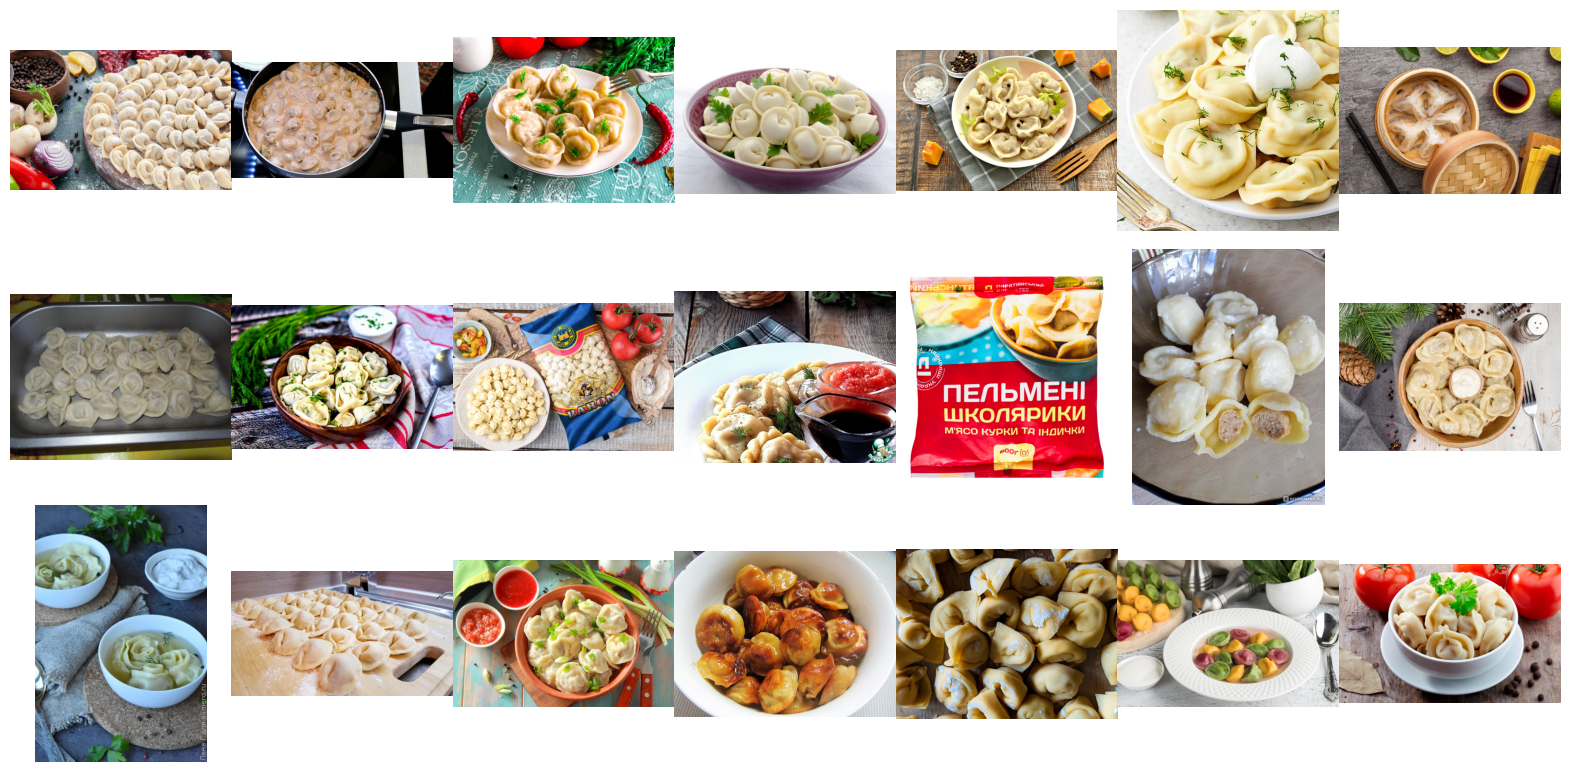

In [14]:
#@title Отобразим случайные изображения из папки
import matplotlib.pyplot as plt
from PIL import Image

# Получаем список всех файлов в папке
image_files = [f for f in os.listdir(download_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Перемешиваем изображения случайным образом
random.shuffle(image_files)

# Определим количество строк и колонок для сетки (например, 3x8)
rows = 3
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# Удалим промежутки между изображениями
plt.subplots_adjust(wspace=0, hspace=0)

# Загрузим и отобразим каждое изображение
for i, ax in enumerate(axes.flatten()):
    if i < len(image_files):
        img_path = os.path.join(download_folder, image_files[i])
        img = Image.open(img_path)
        ax.imshow(img)
    ax.axis('off')  # Скрываем оси

# Показываем изображение на весь экран
plt.show()

In [9]:
# Подключаемся к гугл диску для переноса папки с файлами
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
